# **Project: Amazon Product Recommendation System**

# **Marks: 60**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model. 

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business. 

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:** 
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions. 

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

**Installing surprise library**

In [2]:
import surprise

## **Importing the necessary libraries and overview of the dataset**

In [3]:
# Used to ignore the warning given as output of the code
import warnings
warnings.filterwarnings('ignore')

# Basic libraries of python for numeric and dataframe computations
import numpy as np
import pandas as pd

# Basic library for data visualization
import matplotlib.pyplot as plt

# Slightly advanced library for data visualization
import seaborn as sns

# A dictionary output that does not raise a key error
from collections import defaultdict

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [4]:
data = pd.read_csv('ratings_Electronics.csv')
data.columns = ['user_id', 'prod_id', 'rating', 'timestamp']
df = data.drop('timestamp',axis=1)

In [5]:
df.head()

,user_id,prod_id,rating
0,A2CX7LUOHB2NDG,0321732944,5.0
1,A2NWSAGRHCP8N5,0439886341,1.0
2,A2WNBOD3WNDNKT,0439886341,3.0
3,A1GI0U4ZRJA8WN,0439886341,1.0
4,A1QGNMC6O1VW39,0511189877,5.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824481 entries, 0 to 7824480
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  object 
 1   prod_id  object 
 2   rating   float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product. 

In [7]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:        
        ratings_count[user] += 1
  
    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [8]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [9]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:
    
    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1
    
    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1    

In [10]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_prod = []

for prod, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_prod.append(prod)

df_final = df.loc[~ df.prod_id.isin(remove_prod)]

In [11]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1309,A3LDPF5FMB782Z,1400501466,5.0
1321,A1A5KUIIIHFF4U,1400501466,1.0
1334,A2XIOXRRYX0KZY,1400501466,3.0
1450,AW3LX47IHPFRL,1400501466,5.0
1455,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [12]:
# Check the number of rows and columns and provide observations
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65290 entries, 1309 to 7824426
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


**Write your observations here:** 
- There are 65,290 rows and 3 columns

### **Data types**

In [13]:
# Check Data types and provide observations
df_final.dtypes

user_id     object
prod_id     object
rating     float64
dtype: object

**Write your observations here:** 
- There are 3 data types. User_ID and Prod_ID are both objects, while rating is a float64 type

### **Checking for missing values**

In [14]:
# Check for missing values present and provide observations
missing = df_final.isnull().sum()
duplicate = df_final.duplicated().sum()
print('# of missing : \n', missing, '\n# of duplicates = ', duplicate)

# of missing : 
 user_id    0
prod_id    0
rating     0
dtype: int64 
# of duplicates =  0


**Write your observations here:** 
- There are no missing values in this dataset

### **Summary Statistics**

In [15]:
# Summary statistics of 'rating' variable and provide observations

df_final.describe().T

,count,mean,std,min,25%,50%,75%,max
rating,65290.0,4.294808,0.988915,1.0,4.0,5.0,5.0,5.0


**Write your observations here:**

- the average rating is ~4.29
- the min rating is 1 and the max is 5
- the median rating is also 5

### **Checking the rating distribution**

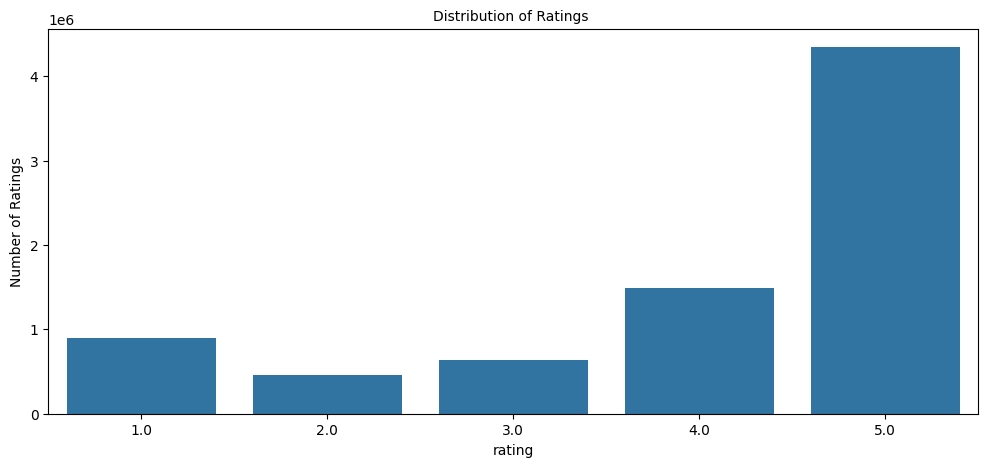

In [16]:
# Create the bar plot and provide observations
# Fix the figure size
plt.figure(figsize = (12, 5))
rating_plt = sns.countplot(x = "rating", data = data)

# Set the labels of the plot
plt.title("Distribution of Ratings ", fontsize = 10)
plt.ylabel("Number of Ratings", fontsize = 10)

# Display the plot
plt.show()



In [17]:
under_5 = df_final.loc[df_final['rating'] != 5].rating.value_counts().sum()
equal_5 = df_final.loc[df_final['rating'] == 5].rating.value_counts().sum()
print('ratings under 5 = ', under_5,'\n# of 5 ratings is = ', equal_5)

ratings under 5 =  28975 
# of 5 ratings is =  36315


**Write your observations here:**
- the 5 rating has the highest frequency followed by the 4 rating
- 5 has over twice the frequency of 4, and it is greater than the frequencies of 1 through 4 combined 
- the 2 rating hasd the lowest frequency of all the ratings


### **Checking the number of unique users and items in the dataset**

In [18]:
# Number of total rows in the data and number of unique user id and product id in the data
row_count = df_final.shape[0]
unique_user = df_final.user_id.nunique()
unique_prod = df_final.prod_id.nunique()
print('# of rows in df: ', row_count)
print('# unique user IDs: ', unique_user)
print('# unique prod IDs: ', unique_prod)

# of rows in df:  65290
# unique user IDs:  1540
# unique prod IDs:  5689


**Write your observations here:**
- there are 65,290 rows in the dataframe
- we have 1540 unique users and 5689 unique products. So we have the potential for 8,761,060 ratings/rows, but we only have 65,290 rows. Therefore, not every user has rated every product

### **Users with the most number of ratings**

In [19]:
# Top 10 users based on the number of ratings
df_final.user_id.value_counts()[:10]

user_id
ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A1UQBFCERIP7VJ    193
A22CW0ZHY3NJH8    193
AWPODHOB4GFWL     184
AGVWTYW0ULXHT     179
Name: count, dtype: int64

In [20]:
# find out if any user has rated the same product more than once
(df_final.groupby(['user_id']).prod_id.value_counts() > 1).sum()

0

**Write your observations here:**
- the user with most ratings **(ADLVFFE4VBT8)** has 295 ratings
- the number 1 user has not rated the other **5689-295 = 5,394** products, so for each user there are at least 5,394 products that are unrated


**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [21]:
# Calculate the average rating for each product 
avg_rating = df_final.groupby(['prod_id']).rating.mean()

# Calculate the count of ratings for each product
rating_count = df_final.groupby(['prod_id']).rating.count()

# Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'avg_rating': avg_rating, 'rating_count': rating_count})

# Sort the dataframe by average of ratings in the descending order
final_rating.sort_values(by='avg_rating',ascending=False, inplace=True)

# See the first five records of the "final_rating" dataset
final_rating.head(10)


,avg_rating,rating_count
prod_id,,
B00LGQ6HL8,5.0,5
B003DZJQQI,5.0,14
B005FDXF2C,5.0,7
B00I6CVPVC,5.0,7
B00B9KOCYA,5.0,8
B003CK10DG,5.0,5
B003B41XYO,5.0,5
B0007WK8KS,5.0,6
B0084FM5JC,5.0,5


In [22]:
final_rating

,avg_rating,rating_count
prod_id,,
B00LGQ6HL8,5.000000,5
B003DZJQQI,5.000000,14
B005FDXF2C,5.000000,7
B00I6CVPVC,5.000000,7
B00B9KOCYA,5.000000,8
...,...,...
B003O2RVGM,1.833333,12
B000ND75C0,1.833333,6
B007C0Y7RI,1.625000,8


In [23]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def popular_products(data, min_interactions, num_top_prod):
    
# Finding products with minimum number of interactions
    pop_prod = data.loc[data['rating_count'] > min_interactions]

# Sorting values with respect to average rating 
    return pop_prod.sort_values(by='avg_rating',ascending=False)[0:num_top_prod]

In [24]:
popular_products(final_rating, 10,5)

,avg_rating,rating_count
prod_id,,
B003DZJQQI,5.0,14
B0012Y6HC8,5.0,15
B00CSDMWGW,5.0,12
B00L3YHF6O,5.0,14
B0000B006W,5.0,12


### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [25]:
popular_products(final_rating, 50,5)

,avg_rating,rating_count
prod_id,,
B001TH7GUU,4.871795,78
B003ES5ZUU,4.864130,184
B0019EHU8G,4.855556,90
B006W8U2MU,4.824561,57
B000QUUFRW,4.809524,84


### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [99]:
popular_products(final_rating, 100,5)

,avg_rating,rating_count
prod_id,,
B003ES5ZUU,4.864130,184
B000N99BBC,4.772455,167
B007WTAJTO,4.701220,164
B002V88HFE,4.698113,106
B004CLYEDC,4.669492,118


We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [27]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them. 

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [28]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)
    
    # Making predictions on the test data
    predictions = model.test(testset)
    
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    
    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)
    
    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)
    
    accuracy.rmse(predictions)
    
    print('Precision: ', precision) # Command to print the overall precision
    
    print('Recall: ', recall) # Command to print the overall recall
    
    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [29]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(1,5))
# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)
# Splitting the data into train and test datasets
trainset, testset = train_test_split(data=data, test_size= 0.2, random_state= 10)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [30]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': True}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
sim_user_user = KNNBasic(sim_options = sim_options, verbose = False, random_state = 1)

# Fit the model on the training data
sim_user_user.fit(trainset=trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(model=sim_user_user)

RMSE: 1.0132
Precision:  0.852
Recall:  0.857
F_1 score:  0.854


**Write your observations here:**
- the RMSE is 1.0132, which means that our model is performing very poorly
- The precision is 85.2%, which means that 85.2% of recommended products are relevant 
- recall is 85.7%, which means that over 85.7% of relevant products are getting recommended to users
- the F-1 score is 85.4%, which is well-balanced between the precision and the recall


Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [31]:
# Predicting rating for a sample user with an interacted product
sim_user_user.predict(uid='A3LDPF5FMB782Z',iid='1400501466', r_ui=5.0, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.00   {'actual_k': 4, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5.0, est=4.0, details={'actual_k': 4, 'was_impossible': False})

**Write your observations here:**
- in the test above, the model predicted a rating of 4.0 while the actual rating was 5.0
- Even though the user-user model has good precision and recall performance, the above test shows that is still underestimating ratings. 
  - Meaning that the model is still underfitting the data as indicated by the RMSE score

Below is the function to find the **list of users who have not seen the product with product id "1400501466"**.

In [32]:
def n_users_not_interacted_with(n, data, prod_id):
    users_interacted_with_product = set(data[data['prod_id'] == prod_id]['user_id'])
    all_users = set(data['user_id'])
    return list(all_users.difference(users_interacted_with_product))[:n] # where n is the number of elements to get in the list

In [33]:
# Find unique user_id where prod_id is not equal to "1400501466"
n_users_not_interacted_with(5, df_final, '1400501466')

['A1EOTB1WHLSW6G',
 'A57Q87B0TC9IJ',
 'A33SX0AD5PYD9B',
 'A30R8VFR16RE32',
 'A1TQBAHI3M4ZBQ']

In [102]:
# This code is to show that user A2UOHALGF2X77Q did not interact with product 1400501466
users_iteracted =  df_final.groupby('prod_id')['user_id'].unique()['1400501466']

# prints the list of users that interacted with product 1400501466 
print(users_iteracted) 

# prints whether user A2UOHALGF2X77Q interacted with product 1400501466
print('A2UOHALGF2X77Q' in users_iteracted)

['A3LDPF5FMB782Z' 'A1A5KUIIIHFF4U' 'A2XIOXRRYX0KZY' 'AW3LX47IHPFRL'
 'A1E3OB6QMBKRYZ' 'A19N3S7CBSU6O7']
False


* It can be observed from the above list that **user "A2UOHALGF2X77Q" has not seen the product with productId "1400501466"** as this user id is a part of the above list.

**Below we are predicting rating for `userId=A2UOHALGF2X77Q` and `prod_id=1400501466`.** 

In [34]:
# Predicting rating for a sample user with a non interacted product
sim_user_user.predict(uid='A2UOHALGF2X77Q',iid='1400501466', verbose=True)

user: A2UOHALGF2X77Q item: 1400501466 r_ui = None   est = 5.00   {'actual_k': 2, 'was_impossible': False}


Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=5, details={'actual_k': 2, 'was_impossible': False})

**Write your observations here:**
- for the user A2UOHALGF2X77Q, who has not intereacted with product 1400501466, we see that the models predicts a rating of 5.0

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise - 
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [35]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 30, 40,50], 
              'min_k': [2, 3, 4, 8],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }
# Performing 3-fold cross-validation to tune the hyperparameters
grid_search = GridSearchCV(KNNBasic, param_grid=param_grid, measures=['rmse'], cv=3, n_jobs= -1)
# Fitting the data
grid_search.fit(data=data)
# Best RMSE score
print(grid_search.best_score['rmse'])
# Combination of parameters that gave the best RMSE score
print(grid_search.best_params['rmse'])


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Computing the msd similarity matrix...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Computing the msd similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Computing the msd similarity matr

Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [36]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options_opt = {'name': 'cosine', 
               'user_based': True}
# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_opt = KNNBasic(k=50, min_k=4, sim_options=sim_options_opt, verbose=False, random_state = 1)
# Training the algorithm on the trainset
sim_user_user_opt.fit(trainset=trainset)
# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(model=sim_user_user_opt)

RMSE: 0.9547
Precision:  0.85
Recall:  0.894
F_1 score:  0.871


**Write your observations here:**
- There is an improvement in the RMSE score, it went from **1.0132 down to 0.9547**
- the precision has gone down slightly, from **0.852 to 0.85**
- Recall has improved, going from **0.857 to 0.894**
- Also, the new F-1 score has also gone up from **0.854 to 0.871**. Which shows an overall improvement in the models performance

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A2UOHALGF2X77Q"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [37]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
sim_user_user_opt.predict(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5.0 ,verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.00   {'actual_k': 4, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5.0, est=4.0, details={'actual_k': 4, 'was_impossible': False})

In [38]:
# Use sim_user_user_optimized model to recommend for userId "A2UOHALGF2X77Q" and productId "1400501466"
sim_user_user_opt.predict(uid='A2UOHALGF2X77Q', iid='1400501466',verbose=True)

user: A2UOHALGF2X77Q item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=4.294053453821412, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Write your observations here:**
- Despite the optimization for KNNBasic, the prediction for user A3LDPF5FMB782Z did not improve. The optimized model still enderestimates the rating as 4.0 instead of 5.0
- It appears that for user A2UOHALGF2X77Q, the model used the global mean for the rating because the user was not able to meet the min_k requirements for the KNN algorithm

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [39]:
# 0 is the inner id of the above user
sim_user_user_opt.get_neighbors(iid=0,k=5)

[4, 6, 8, 12, 14]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [40]:
def get_recommendations(data, user_id, top_n, algo):
    
    # Creating an empty list to store the recommended product ids
    recommendations = []
    
    # Creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')
    
    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:
        
        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est
        
        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [41]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
top_5_reccomendations = get_recommendations(data=df_final, user_id='A3LDPF5FMB782Z', top_n=5, algo=sim_user_user_opt)
top_5_reccomendations

[('B00006RVPW', 5),
 ('B00007IFED', 5),
 ('B0000BVYTV', 5),
 ('B000144I2Q', 5),
 ('B00020S7XK', 5)]

In [42]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
prod_predict = pd.DataFrame(data=top_5_reccomendations,columns=['prod_id','predicted_ratings'])
prod_predict

,prod_id,predicted_ratings
0,B00006RVPW,5
1,B00007IFED,5
2,B0000BVYTV,5
3,B000144I2Q,5
4,B00020S7XK,5


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**. 

In [43]:
# Declaring the similarity options
sim_options_opt = {'name': 'cosine', 
               'user_based': False}
# KNN algorithm is used to find desired similar items. Use random_state=2
sim_item_item = KNNBasic(sim_options=sim_options_opt, verbose=False, random_state = 2)
# Train the algorithm on the trainset, and predict ratings for the test set
sim_item_item.fit(trainset=trainset)
# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_item_item)

RMSE: 1.0112
Precision:  0.829
Recall:  0.845
F_1 score:  0.837


**Write your observations here:**
- the RMSE is 1.011 which is slightly better than the unoptimized user-user filter score (1.013), but it is still very high which means that our model is performing very poorly
- The item-item precision is 82.9%, which is lower than the user-user precision of 85.2%
- The item-item recall is 84.5%, which is lower than the user-user recall of 85.7%
- the F-1 score is 83.7%, which is lower than the user-user F1-score of 85.4%

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [44]:
# Predicting rating for a sample user with an interacted product
sim_item_item.predict(uid='A3LDPF5FMB782Z',iid='1400501466',verbose=True, r_ui=5)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.24   {'actual_k': 21, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.238095238095238, details={'actual_k': 21, 'was_impossible': False})

**Write your observations here:**
- the item-item prediction for user A3LDPF5FMB782Z is 4.24, which is higher than the optimized user-user prediciton

Below we are **predicting rating for the `userId = A2UOHALGF2X77Q` and `prod_id = 1400501466`**.

In [45]:
# Predicting rating for a sample user with a non interacted product
sim_item_item.predict(uid='A2UOHALGF2X77Q',iid='1400501466',verbose=True)

user: A2UOHALGF2X77Q item: 1400501466 r_ui = None   est = 4.50   {'actual_k': 2, 'was_impossible': False}


Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=4.5, details={'actual_k': 2, 'was_impossible': False})

**Write your observations here:**
- the item-item prediction for user A2UOHALGF2X77Q is 4.5

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters 

In [46]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {
  'k': [10, 20, 30],
  'min_k': [3, 6, 9],
  'sim_options': {'name': ['msd', 'cosine'],
                  'user_based': [False]}
}
# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(algo_class=KNNBasic, param_grid=param_grid, measures=['rmse'], n_jobs=-1, cv=3)
# Fitting the data
gs.fit(data)
# Find the best RMSE score
print(gs.best_score['rmse'])
# Find the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

Computing the msd similarity matrix...
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matr

Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [47]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': 'msd',
               'user_based': False}
# Creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(sim_options = sim_options, k = 30, min_k = 6, random_state = 3, verbose = False)
# Training the algorithm on the trainset
sim_item_item_optimized.fit(trainset)
# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(sim_item_item_optimized)

RMSE: 0.9613
Precision:  0.838
Recall:  0.892
F_1 score:  0.864


**Write your observations here:**
- the RMSE has gone down to 0.961 which better but is not as good as the optimized user-user filter score (0.955)
- The optimized item-item precision is 83.8%, which is not as good as the optimized user-user precision of 85%. 
- The opt. item-item recall is 89.2%, which is lower than the opt. user-user recall of 89.4%
- the F-1 score is 86.4%, which is lower than the user-user F1-score of 87.1%
- overall, the optimized item-item model isn't as good as the optimized user-user model.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A2UOHALGF2X77Q"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [101]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
sim_item_item_optimized.predict(uid='A3LDPF5FMB782Z',iid='1400501466',verbose=True, r_ui=5.0)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.70   {'actual_k': 21, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5.0, est=4.697431781701445, details={'actual_k': 21, 'was_impossible': False})

In [59]:
# Use sim_item_item_optimized model to recommend for userId "A2UOHALGF2X77Q" and productId "1400501466"
sim_item_item_optimized.predict(uid='A2UOHALGF2X77Q',iid='1400501466',verbose=True)

user: A2UOHALGF2X77Q item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=4.294053453821412, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Write your observations here:**
- the optimized prediciton for **A3LDPF5FMB782Z** is 4.70 which is closest prediciton to real rating yet.

    - surprisingly, this prediction is closer to the actual rating than what the opt. user-user model returned
- the prediction for **A2UOHALGF2X77Q** is 4.29, which makes sense since it did not meat the min_k requirement so the model out the global mean instead. Which is equal to the opt. user-user model.

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [69]:
# 0 is the inner id of the above item
sim_item_item_optimized.get_neighbors(iid=0,k=5)

[21, 46, 47, 52, 69]

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [50]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
rec_items = get_recommendations(data=df_final,user_id='A1A5KUIIIHFF4U',top_n=5,algo=sim_item_item_optimized)

In [51]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
prod_rec_df = pd.DataFrame(data=rec_items, columns=['prod_id','predicted_ratings'])
prod_rec_df

,prod_id,predicted_ratings
0,1400532655,4.294053
1,1400599997,4.294053
2,9983891212,4.294053
3,B00000DM9W,4.294053
4,B00000J1V5,4.294053


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [52]:
# Using SVD matrix factorization. Use random_state = 1
svd_alg = SVD(random_state=1)
# Training the algorithm on the trainset
svd_alg.fit(trainset)
# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(model=svd_alg)

RMSE: 0.8978
Precision:  0.846
Recall:  0.879
F_1 score:  0.862


**Write your observations here:**
- the RMSE is 0.8978, the best return out of all the models
- precision is 84.6%, better than the unoptimized item-item model
- recall is 87.9%, better than unoptimized user and item models
- F-1 score is 86.2%, better than unoptimized user and item models

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [100]:
# Making prediction
svd_alg.predict(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5.0, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.31   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5.0, est=4.31349912025027, details={'was_impossible': False})

**Write your observations here:**
- the model predicted that user A3LDPF5FMB782Z would give a rating of 4.31 (the actual rating is 5.0)
- this is a better prediction than all the user-user models and the unoptimized item-item model 

**Below we are predicting rating for the `userId = "A2UOHALGF2X77Q"` and `productId = "1400501466"`.**

In [54]:
# Making prediction
svd_alg.predict(uid='A2UOHALGF2X77Q', iid='1400501466', verbose=True)

user: A2UOHALGF2X77Q item: 1400501466 r_ui = None   est = 4.23   {'was_impossible': False}


Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=4.231948173645187, details={'was_impossible': False})

**Write your observations here:**
- The model predicted a rating of 4.23 from user A2UOHALGF2X77Q

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [91]:
# Set the parameter space to tune
param_grid = {
  'n_epochs': [10, 15, 20, 25],
  'lr_all': [0.001, 0.005, 0.01, 0.015],
  'reg_all': [0.1, 0.2, 0.3, 0.4]
}
# Performing 3-fold gridsearch cross-validation
gs = GridSearchCV(algo_class=SVD, param_grid=param_grid, measures=['rmse'], n_jobs=-1, cv=3)
# Fitting data
gs.fit(data=data)
# Best RMSE score
print(gs.best_score['rmse'])
# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8983264327705512
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.3}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [90]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
svd_opt = SVD(n_epochs=20, lr_all=0.01,reg_all=0.3, random_state=5)
# Train the algorithm on the trainset
svd_opt.fit(trainset)
# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_opt)

RMSE: 0.8882
Precision:  0.845
Recall:  0.879
F_1 score:  0.862


**Write your observations here:**
- the RMSE slightly reduced to 0.8882
- the precision when down slightly, it is now 84.5%
- recall remained at 87.9%
- F-1 score also remained the same at 86.2%

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A2UOHALGF2X77Q"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [57]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
svd_opt.predict(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5.0, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.50   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5.0, est=4.495762070535066, details={'was_impossible': False})

In [58]:
# Use svd_algo_optimized model to recommend for userId "A2UOHALGF2X77Q" and productId "1400501466"
svd_opt.predict(uid='A2UOHALGF2X77Q', iid='1400501466', verbose=True)

user: A2UOHALGF2X77Q item: 1400501466 r_ui = None   est = 4.32   {'was_impossible': False}


Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=4.3248215971882304, details={'was_impossible': False})

### **Conclusion and Recommendations**

**Write your conclusion and recommendations here**
- For a brand new user, the rank-based system is the most logical choice and the one I recommend for two reasons.
    1) It does not require prior item interactions from the user
    2) the EDA showed that the number of 5 ratings is significantly more than the combined frequency of ratings 1 through 4. So, Amazon has several items of proven quality that they can recommend to a brand new user
- The user-user and item-item models performed comparably to each other in both the optimized and unoptimized versions.
    - A concern I found was that the optimized item model performed better for test user **A3LDPF5FMB782Z** than any other model despite having lower performance metrics than the optimized user-user or matrix factorization models.
        - Though the way the centroids were chosen by the KNN algorithm most likely played a factor.
    - Out of all the collaborative filtering models, I still recommend the optimized user-user model due to its higher recall and precision values.
- The matrix factorization model performed the best out of all the models (not including rank-based) and it is the one I recommend the most.
    - Even unoptimized it has a significantly better RMSE and a comparable F1-score to the optimized collaborative models.
    - However, I would not recommend the optimized model. I found that I spent a good deal of time trying to fine tune the hyperparameters, which ended up providing the slightest improvement in the models performance.

